# Mini Materials Knowledge Graph — Common Semiconductors
**What I'm building:** a tiny pipeline that turns a small semiconductors table into **RDF triples**, then I query it using **SPARQL**. I keep the ontology minimal and readable.


## Some basic terminologies
- **Ontology** → my small schema + vocabulary for this domain (classes + relations).
- **RDF (Resource Description Framework) triple** → one fact written as `subject — predicate — object`.
- **Namespace** → URL prefix so my identifiers are unique.
- **SPARQL** → my query tool for RDF graphs (like SQL but for triples).
- **Turtle (.ttl)** → compact text format to store RDF.
- **IRI(Internationalized Resource Identifier)** → a **Unicode string** that serves as a unique, global name or identifier for an entity.


**Imports**

In [ ]:
# import os; print("OK" if os.getenv("OPENAI_API_KEY") else "MISSING")

OK


In [12]:
import pandas as pd
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD
from pathlib import Path
import re
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import json, ast
from matminer.featurizers.structure import GlobalSymmetryFeatures
from pymatgen.core import Structure
import openpyxl

# 0) Dataset prep. for KG

In [16]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from pymatgen.core import Structure, Lattice
from matminer.featurizers.structure import GlobalSymmetryFeatures

# -------- Paths (notebook in .../notebooks, data in .../data) ----------
DATA_DIR   = Path("../data").resolve()
INPUT_XLSX = DATA_DIR / "full_dataset_Bandgap_0_to_5.xlsx"
OUTPUT_CSV = DATA_DIR / "full_dataset_Bandgap_0_to_5_featurized.csv"

# -------- Regex helpers for the pretty string ----------
re_abc     = re.compile(r"abc\s*:\s*([-\d\.Ee+]+)\s+([-\d\.Ee+]+)\s+([-\d\.Ee+]+)", re.I)
re_angles  = re.compile(r"angles\s*:\s*([-\d\.Ee+]+)\s+([-\d\.Ee+]+)\s+([-\d\.Ee+]+)", re.I)
re_pbc     = re.compile(r"pbc\s*:\s*(True|False)\s+(True|False)\s+(True|False)", re.I)
re_sites_header = re.compile(r"Sites\s*\(\d+\)", re.I)
re_site_row = re.compile(
    r"^\s*\d+\s+([A-Za-z][a-z]?)\s+([-\d\.Ee+]+)\s+([-\d\.Ee+]+)\s+([-\d\.Ee+]+)",
    re.I
)

def parse_pretty_structure(txt):
    """Parse pymatgen's pretty-printed Structure summary into a Structure."""
    if not isinstance(txt, str):
        return None
    s = txt.strip()

    # Lattice params
    m_abc = re_abc.search(s)
    m_ang = re_angles.search(s)
    if not (m_abc and m_ang):
        return None
    a, b, c = map(float, m_abc.groups())
    alpha, beta, gamma = map(float, m_ang.groups())

    # PBC (optional; default True,True,True)
    m_pbc = re_pbc.search(s)
    pbc = tuple(map(lambda x: x.lower()=="true", m_pbc.groups())) if m_pbc else (True, True, True)

    # Sites block: find header, then parse subsequent lines
    lines = s.splitlines()
    try:
        start_idx = next(i for i, ln in enumerate(lines) if re_sites_header.search(ln))
    except StopIteration:
        return None

    species, frac_coords = [], []
    for ln in lines[start_idx+1:]:
        m = re_site_row.match(ln)
        if not m:
            continue
        sp, fa, fb, fc = m.groups()
        species.append(sp)
        frac_coords.append([float(fa), float(fb), float(fc)])

    if not species:
        return None

    # Build lattice & structure
    lat = Lattice.from_parameters(a=a, b=b, c=c, alpha=alpha, beta=beta, gamma=gamma)
    try:
        # pymatgen Structure ignores PBC per-axis in initializer; periodicity is assumed.
        # If you truly need non-periodic axes, you'd manage it downstream; for symmetry it's fine.
        struct = Structure(lattice=lat, species=species, coords=frac_coords, coords_are_cartesian=False)
        return struct
    except Exception:
        return None

# -------- Load Excel ----------
df = pd.read_excel(INPUT_XLSX)

# Choose/confirm structure column (adjust if yours is named differently)
struct_col = "structure" if "structure" in df.columns else None
if struct_col is None:
    # try a best-guess search for a column that contains the pretty summary
    candidates = [c for c in df.columns if df[c].astype(str).str.contains(r"Full Formula|Reduced Formula|Sites \(", regex=True, na=False).any()]
    struct_col = candidates[0] if candidates else None

if struct_col is None:
    raise ValueError(f"Could not find the structure column. Available columns: {list(df.columns)}")

# -------- Parse structures --------
parsed = df[struct_col].apply(parse_pretty_structure)

parsed_ok = parsed.apply(lambda x: isinstance(x, Structure))
print(f"Parsed {parsed_ok.sum()} / {len(parsed)} structures ({100*parsed_ok.mean():.1f}%).")

if parsed_ok.sum() == 0:
    raise RuntimeError("Parser could not reconstruct any structures from the pretty string format. "
                       "Please share one exact cell (as plain text) or consider storing CIF/JSON for structures.")

# Replace column with parsed Structure objects
df[struct_col] = parsed

# -------- Featurize (two features only) --------
gsf = GlobalSymmetryFeatures()
labels = gsf.feature_labels()  # ['spacegroup_num','crystal_system','crystal_system_int','is_centrosymmetric','n_symmetry_ops']

records = []
for s in df[struct_col]:
    if isinstance(s, Structure):
        try:
            vals = gsf.featurize(s)
            rec = dict(zip(labels, vals))
        except Exception:
            rec = {lbl: np.nan for lbl in labels}
    else:
        rec = {lbl: np.nan for lbl in labels}
    records.append(rec)

feat_df = pd.DataFrame(records)
out_df = pd.concat([df.reset_index(drop=True),
                    feat_df[["crystal_system", "is_centrosymmetric"]].reset_index(drop=True)], axis=1)

# -------- Save --------
out_df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved: {OUTPUT_CSV}")
print(out_df[["crystal_system", "is_centrosymmetric"]].isna().mean())
out_df.head()

Parsed 150987 / 150987 structures (100.0%).
Saved: E:\Projects\Semantic_models_for-MSE\data\full_dataset_Bandgap_0_to_5_featurized.csv
crystal_system        0.0
is_centrosymmetric    0.0
dtype: float64


,material_id,formula,band_gap,structure,crystal_system,is_centrosymmetric
0,mp-10018,Ac,0.0,[[0. 0. 0.] Ac],cubic,True
1,mp-1183057,Ac,0.0,[[1.31096178e+00 2.27065255e+00 3.21093059e-16...,trigonal,False
2,mp-1183069,Ac,0.0,"[[0. 0. 0.] Ac, [2.65892229 0.77478234 2.89079...",trigonal,True
3,mp-862690,Ac,0.0,"[[0. 0. 0.] Ac, [-3.26165376e-07 2.33598734e+...",hexagonal,True
4,mp-861724,Ac2AgIr,0.0,"[[3.10657746 2.19668199 5.38075 ] Ac, [0. 0....",cubic,True


## 1) Setup
read a tiny CSV and map it into RDF using `rdflib`.


In [17]:
# DATA = Path("../data/semiconductors_small.csv")   # CSV lives in the repo
# TTL_OUT = Path("../data/semiconductors_small.ttl")# RDF Turtle output
# print("Using data:", DATA.resolve())

DATA    = Path("../data/full_dataset_Bandgap_0_to_5_featurized.csv")  # input CSV
TTL_OUT = Path("../data/full_dataset_Bandgap_0_to_5.ttl")             # RDF Turtle output

print("Using data:", DATA.resolve())
print("Will write TTL:", TTL_OUT.resolve())

Using data: E:\Projects\Semantic_models_for-MSE\data\full_dataset_Bandgap_0_to_5_featurized.csv
Will write TTL: E:\Projects\Semantic_models_for-MSE\data\full_dataset_Bandgap_0_to_5.ttl



## 2) Ontology skeleton (small and pragmatic)
a few classes and properties that I actually need for the initial CSV i am using.  
Classes: `Material`, `SynthesisMethod`, `CrystalStructure`, `Property`  
Properties:  
- data: `hasBandGap` (float eV), `hasLatticeConstant` (float Å)  
- object: `hasCrystalStructure`, `synthesizedBy`

- the final dataset will have: structure (crystal system and inversion center), composition and bandgap.  

3 class declarations (Material, CrystalStructure, Property) → 3  
4 property declarations (hasBandGap, hasFormula, hasExternalId, hasCrystalStructure) → 5  
5×(domain + range) annotations → 10 for each prperty    
Total = 3 + 5 + 10 = 18 triples.

In [18]:
# Ontology skeleton for: material_id, formula, band_gap, crystal_system, is_centrosymmetric
# (structure captured via crystal system + inversion center only)

from rdflib import Graph, Namespace, RDF, RDFS, XSD

g = Graph()

# Namespaces
EX = Namespace("http://example.org/mse#")
g.bind("ex", EX)
g.bind("rdfs", RDFS)
g.bind("xsd", XSD)

# Classes
Material         = EX.Material
CrystalStructure = EX.CrystalStructure
Property         = EX.Property  # generic placeholder

for cls in [Material, CrystalStructure, Property]:
    g.add((cls, RDF.type, RDFS.Class))

# Datatype properties (aligned to featurized CSV)
hasExternalId     = EX.hasExternalId        # -> material_id
hasFormula        = EX.hasFormula           # -> formula (composition string)
hasBandGap        = EX.hasBandGap           # -> band_gap (eV)
hasCrystalSystem  = EX.hasCrystalSystem     # -> crystal_system (e.g., cubic, hexagonal)
hasCentrosymmetric= EX.hasCentrosymmetric   # -> is_centrosymmetric (True/False)

for prop in [hasExternalId, hasFormula, hasBandGap, hasCrystalSystem, hasCentrosymmetric]:
    g.add((prop, RDF.type, RDF.Property))

# Domain/Range annotations
g.add((hasExternalId,      RDFS.domain, Material)); g.add((hasExternalId,      RDFS.range, XSD.string))
g.add((hasFormula,         RDFS.domain, Material)); g.add((hasFormula,         RDFS.range, XSD.string))
g.add((hasBandGap,         RDFS.domain, Material)); g.add((hasBandGap,         RDFS.range, XSD.float))
g.add((hasCrystalSystem,   RDFS.domain, Material)); g.add((hasCrystalSystem,   RDFS.range, XSD.string))
g.add((hasCentrosymmetric, RDFS.domain, Material)); g.add((hasCentrosymmetric, RDFS.range, XSD.boolean))

print("Ontology initialized (structure via crystal_system + inversion center, plus composition & bandgap).")
print("Triples so far:", len(g))

Ontology initialized (structure via crystal_system + inversion center, plus composition & bandgap).
Triples so far: 18


## 3) Load CSV and mint entities  
create IRIs (Internationalized Resource Identifier) from labels (simple normalization) and assert triples for each row.

In [19]:
# --- 1) Read CSV and canonicalize headers for THIS project (no synthesis, no lattice const) ---
# Featurized CSV columns: material_id, formula, band_gap, crystal_system, is_centrosymmetric
import pandas as pd, re
from rdflib import Literal, RDF, RDFS, XSD, URIRef

# load
df_raw = pd.read_csv(DATA)

# rename to stable names my code will use everywhere
df = df_raw.rename(columns={
    "material_id":        "material_id",
    "formula":            "formula",
    "band_gap":           "band_gap_eV",
    "crystal_system":     "crystal_system",
    "is_centrosymmetric": "is_centrosymmetric",
}).copy()

# create a human label for the Material (use formula as the label)
df["material_label"] = df["formula"]

# enforce dtypes
for col in ["material_label", "formula", "material_id", "crystal_system"]:
    if col in df.columns:
        df[col] = df[col].astype("string")
df["band_gap_eV"] = pd.to_numeric(df.get("band_gap_eV"), errors="coerce")
if "is_centrosymmetric" in df.columns:
    # normalize truthy strings (e.g., "True"/"FALSE"/"1"/"0")
    df["is_centrosymmetric"] = df["is_centrosymmetric"].map(
        lambda x: bool(int(x)) if str(x).strip() in {"1","0"} else
                  (str(x).strip().lower() == "true") if pd.notna(x) else None
    )

# --- 2) Helpers (consistent across the notebook) ---
def _slugify(text: str) -> str:
    text = str(text).strip().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    text = re.sub(r"[^A-Za-z0-9_]", "_", text)
    return text

def mint_entity(label, cls: URIRef, fallback_prefix: str, idx: int):
    if label is None or (pd.isna(label) if hasattr(pd, "isna") else label is None) or str(label).strip() == "":
        safe = f"{fallback_prefix}_{idx}"
        iri  = EX[safe]
        g.add((iri, RDF.type, cls))
        g.add((iri, RDFS.label, Literal(f"{fallback_prefix} #{idx}")))
        return iri
    label_str = str(label)
    safe = _slugify(label_str)
    iri  = EX[safe]
    g.add((iri, RDF.type, cls))
    g.add((iri, RDFS.label, Literal(label_str)))
    return iri

print("Data loaded. Rows:", len(df))
print("Columns:", list(df.columns))

Data loaded. Rows: 150987
Columns: ['material_id', 'formula', 'band_gap_eV', 'structure', 'crystal_system', 'is_centrosymmetric', 'material_label']


## 4) Serialize to Turtle
write the RDF graph to a `.ttl` file so it’s versionable in Git and easy to inspect.


In [20]:
# --- Serialize graph to Turtle ---
# encoding="utf-8" ensures rdflib returns bytes
ttl_bytes = g.serialize(format="turtle", encoding="utf-8")
TTL_OUT.write_bytes(ttl_bytes)

# quick sanity check
p = TTL_OUT.resolve()
print("Wrote:", p)
print("Triples in graph:", len(g))
print("File size (bytes):", p.stat().st_size)

Wrote: E:\Projects\Semantic_models_for-MSE\data\full_dataset_Bandgap_0_to_5.ttl
Triples in graph: 18
File size (bytes): 768



## 5) SPARQL queries (quick checks)
query the in‑memory graph via `rdflib` to verify the ontology + data mapping.


In [41]:
# Q1) Materials with band gap > 1 eV (descending)
q1 = """
PREFIX ex: <http://example.org/mse#>
SELECT ?formula ?id ?Eg
WHERE {
  ?m a ex:Material ;
     rdfs:label ?formula ;
     ex:hasBandGap ?Eg .
  OPTIONAL { ?m ex:hasExternalId ?id }
  FILTER(?Eg > 1.0)
}
ORDER BY DESC(?Eg)
LIMIT 20
"""
for row in g.query(q1, initNs={"rdfs": RDFS}):
    print(row)

In [7]:
# Q2) Materials synthesized by MOCVD
q2 = """PREFIX ex: <http://example.org/mse#>
SELECT ?material
WHERE {
  ?m a ex:Material ;
     rdfs:label ?material ;
     ex:synthesizedBy ?meth .
  ?meth rdfs:label "MOCVD" .
}
"""
for row in g.query(q2, initNs={"rdfs": RDFS}):
    print(row)

In [ ]:
# Q3) Materials with diamond cubic structure
q3 = """PREFIX ex: <http://example.org/mse#>
SELECT ?material
WHERE {
  ?m a ex:Material ;
     rdfs:label ?material ;
     ex:hasCrystalStructure ?cs .
  ?cs rdfs:label "Diamond cubic" .
}
"""
for row in g.query(q3, initNs={"rdfs": RDFS}):
    print(row)

## 6) Creating safeguard for possible problems in data scrapping!!
keep a few small rules here to catch obvious issues (labels missing, negative band gaps, etc.).

In [21]:
problems = []

# A) All Materials should have labels
for s in g.subjects(RDF.type, EX.Material):
    if not any(True for _ in g.objects(s, RDFS.label)):
        problems.append(f"Material without label: {s}")

# B) Band gap must be numeric and non-negative
for s, p, o in g.triples((None, EX.hasBandGap, None)):
    try:
        val = float(o.toPython())
        if val < 0:
            problems.append(f"Negative band gap for {s}")
    except Exception:
        problems.append(f"Non-numeric band gap for {s}: {o}")

print("No obvious problems ✅" if not problems else "Consistency problems:")
for x in problems:
    print("-", x)

No obvious problems ✅



## 7) Placeholder for LLM‑assisted extraction
When I replace this stub with a real LLM/NLP call, I’ll feed abstracts/tables and get back candidate triples to add to the graph.


In [22]:
def propose_triples_from_text(text: str):
    """
    Demo placeholder:
    Pretend we parsed that 'GaN has Eg ~3.4 eV'.
    Later this can be swapped for NLP/LLM-based extraction.
    """
    return [(EX.GaN, EX.hasBandGap, Literal(3.4, datatype=XSD.float))]

# Insert demo triples
for s, p, o in propose_triples_from_text("GaN has band gap ~3.4 eV"):
    g.add((s, p, o))

print("Triples after stub insert:", len(g))

Triples after stub insert: 19



## 8) Save again after updates
I keep the TTL in sync with the in‑memory graph.


In [23]:
# --- Update the TTL file with new triples ---
TTL_OUT.write_bytes(g.serialize(format="turtle", encoding="utf-8"))

print("Updated:", TTL_OUT.resolve())
print("Triples now in graph:", len(g))

Updated: E:\Projects\Semantic_models_for-MSE\data\full_dataset_Bandgap_0_to_5.ttl
Triples now in graph: 19


## 9: Plotting a knowledge graph

In [12]:
from pyvis.network import Network
from rdflib import Graph, URIRef, BNode, Literal


def display_label(term):
    """Human label for a node/edge: prefer rdfs:label, then QName, then short str."""
    lab = g.value(term, RDFS.label)
    if lab:
        return str(lab).strip()
    # QName only for URIRefs
    if isinstance(term, URIRef):
        try:
            return g.namespace_manager.normalizeUri(term)
        except Exception:
            pass
    s = str(term).strip()
    return s

def node_id(term):
    """Stable ID for pyvis (avoid raw labels)."""
    # Use actual URI for URIRefs/BNodes; fallback to hash
    if isinstance(term, (URIRef, BNode)):
        return str(term)
    return f"lit:{hash((str(term), type(term).__name__))}"

def node_style(term):
    """Color by class where possible (Material / CrystalStructure / SynthesisMethod)."""
    # Try to infer from rdf:type (lightweight check)
    types = set(g.objects(term, RDF.type)) if isinstance(term, (URIRef, BNode)) else set()
    # Resolve EX namespace if present
    ns = dict(g.namespace_manager.namespaces())
    EX = ns.get("ex")
    def is_type(tname):
        return any(str(t).endswith(f"#{tname}") or str(t).endswith(f"/{tname}") for t in types)
    if is_type("Material"):
        return dict(color="#2b8a3e", shape="ellipse")
    if is_type("CrystalStructure"):
        return dict(color="#1c7ed6", shape="ellipse")
    if is_type("SynthesisMethod"):
        return dict(color="#e8590c", shape="ellipse")
    if isinstance(term, Literal):
        return dict(color="#bfbfbf", shape="box")
    return dict(color="#666666", shape="ellipse")

def visualize_graph_pyvis(g, max_edges=1500, show_literals=False, height="700px"):
    net = Network(height=height, width="100%", directed=True, notebook=True,
                  cdn_resources="in_line")  # avoid the Jupyter warning
    net.toggle_physics(True)

    added = set()
    edge_count = 0

    for s, p, o in g.triples((None, None, None)):
        if edge_count >= max_edges:
            break

        # skip literal nodes unless asked
        if not show_literals and isinstance(o, Literal):
            # still add edge to a small boxed literal if you like:
            # continue
            pass

        sid = node_id(s); so = node_id(o)
        if sid not in added:
            net.add_node(sid, label=display_label(s), **node_style(s))
            added.add(sid)
        if show_literals or not isinstance(o, Literal):
            if so not in added:
                net.add_node(so, label=display_label(o), **node_style(o))
                added.add(so)

        net.add_edge(sid, so, label=display_label(p))
        edge_count += 1

    net.show("kg.html")
    print("Wrote: kg.html (open this file in your browser)")

visualize_graph_pyvis(g, max_edges=1000, show_literals=True)

kg.html
Wrote: kg.html (open this file in your browser)


# Utilizing LLM (Chat GPT) for parsing

*Quick smoke test*
-Chat GPT: doesnt support api access for plus user.

In [13]:
# from openai import OpenAI
# import os, json

# assert os.getenv("OPENAI_API_KEY"), "API key missing"
# client = OpenAI()

# resp = client.chat.completions.create(
#     model="gpt-4o-mini",
#     response_format={"type": "json_object"},   # ← JSON mode
#     messages=[
#         {"role":"system","content":"Return valid JSON only."},
#         {"role":"user","content":"Respond with {\"ok\": true}"}
#     ],
#     temperature=0
# )
# print(json.loads(resp.choices[0].message.content))

*Quick smoke test*  
-OLLAMA offers llms to be run on local machines and an API.

In [14]:
import json, ollama
r = ollama.chat(
    model='llama3.2:3b',
    messages=[{"role":"system","content":"Return ONLY valid JSON."},
              {"role":"user","content":'{"ok": true}'}],
    format='json',
    options={'temperature': 0}
)
print(json.loads(r['message']['content']))

{'ok': True}


**Wiring 'ollama'into the pipeline.**  
1. Schema

In [15]:
from pydantic import BaseModel, Field, ValidationError
from typing import Optional

class RowOut(BaseModel):
    material: str
    crystal_structure: str
    typical_synthesis: str
    band_gap_eV: Optional[float] = Field(default=None, ge=0)
    lattice_const_A: Optional[float] = Field(default=None, ge=0)

2. Building 'hints' from data

In [16]:
# assumes your DataFrame is named df
allowed_structs  = sorted(set(str(x).strip() for x in df['crystal_structure'].dropna()))
allowed_methods  = sorted(set(str(x).strip() for x in df['typical_synthesis'].dropna()))

3. Normalization of data-row (that're gonna be parsed) with 'ollama'

In [17]:
import json, ollama

SYSTEM = f"""You are a materials KG assistant.
Return ONLY JSON with keys exactly:
material, crystal_structure, typical_synthesis, band_gap_eV, lattice_const_A.
Rules:
- Normalize names (e.g., crystal structure like 'Diamond' / 'Cubic').
- Use null if a numeric field is unknown.
- Units: band_gap_eV in eV; lattice_const_A in Å (floats).
- Preferred crystal_structure values (if applicable): {allowed_structs}
- Preferred typical_synthesis values (if applicable): {allowed_methods}
"""

def normalize_row_with_ollama(row: dict) -> RowOut:
    msg = f"Normalize this row to the schema: {row}"
    resp = ollama.chat(
        model='llama3.2:3b',
        messages=[{"role":"system","content": SYSTEM},
                  {"role":"user","content": msg}],
        format='json',                 # forces valid JSON
        options={'temperature': 0}     # deterministic
    )
    data = json.loads(resp['message']['content'])
    try:
        return RowOut(**data)
    except ValidationError:
        # minimal fallback coercions
        return RowOut(
            material=str(data.get("material","")).strip() or "Unknown",
            crystal_structure=str(data.get("crystal_structure","")).strip() or "Unknown",
            typical_synthesis=str(data.get("typical_synthesis","")).strip() or "Unknown",
            band_gap_eV=(float(data["band_gap_eV"]) if data.get("band_gap_eV") not in (None,"") else None),
            lattice_const_A=(float(data["lattice_const_A"]) if data.get("lattice_const_A") not in (None,"") else None),
        )

4. Appending normalized result into my graph

In [18]:
from rdflib import Literal, XSD

def ingest_normalized_row(nr: RowOut, idx: int = 0):
    mat = mint_entity(nr.material,          Material,         "Material",         idx)
    cs  = mint_entity(nr.crystal_structure,  CrystalStructure, "CrystalStructure", idx)
    sm  = mint_entity(nr.typical_synthesis,  SynthesisMethod,  "SynthesisMethod",  idx)

    if nr.band_gap_eV is not None:
        g.add((mat, hasBandGap, Literal(float(nr.band_gap_eV), datatype=XSD.float)))
    if nr.lattice_const_A is not None:
        g.add((mat, hasLatticeConstant, Literal(float(nr.lattice_const_A), datatype=XSD.float)))

    g.add((mat, hasCrystalStructure, cs))
    g.add((mat, synthesizedBy, sm))

5. Pre-Scale-up confirmations  
a. Pipeline test

In [19]:
# single example
sample = df.iloc[0].to_dict()
nr = normalize_row_with_ollama(sample)
ingest_normalized_row(nr, idx=0)
print("Triples now:", len(g))

# small batch (e.g., first 5 rows) 
for i, r in df.head(5).iterrows():
    nr = normalize_row_with_ollama(r.to_dict())
    ingest_normalized_row(nr, idx=i)

print("Triples after LLM ingest:", len(g))

Triples now: 26
Triples after LLM ingest: 56


In [20]:
# import inspect
# print(inspect.signature(mint_entity))
# print(mint_entity.__code__.co_filename, mint_entity.__code__.co_firstlineno)

b. Quick peek to existing, parsed csv.  

b.1: load the dataframe

In [22]:
import pandas as pd
import numpy as np

# if df already exists, keep it; else read it in consistently
try:
    df
    assert all(c in df.columns for c in ["material","crystal_structure","typical_synthesis","band_gap_eV","lattice_const_A"])
except:
    # NOTE: DATA should already point to your CSV path from earlier cells.
    # if not, set DATA = "path/to/semiconductors_small.csv"
    STRING_COLS = ["material", "crystal_structure", "typical_synthesis"]
    df = pd.read_csv(DATA, dtype={col: "string" for col in STRING_COLS})
    df["band_gap_eV"]     = pd.to_numeric(df.get("band_gap_eV"), errors="coerce")
    df["lattice_const_A"] = pd.to_numeric(df.get("lattice_const_A"), errors="coerce")

print("rows x cols:", df.shape)
df.head(8)

rows x cols: (7, 6)


,material,formula,band_gap_eV,crystal_structure,lattice_const_A,typical_synthesis
0,Silicon,Si,1.12,Diamond cubic,5.431,Czochralski
1,Germanium,Ge,0.66,Diamond cubic,5.658,Czochralski
2,Gallium Arsenide,GaAs,1.42,Zinc blende,5.653,MBE
3,Indium Phosphide,InP,1.34,Zinc blende,5.869,MOCVD
4,Gallium Nitride,GaN,3.40,Wurtzite,3.189,MOCVD
5,Silicon Carbide (4H),SiC,3.26,Hexagonal,3.073,PVT
6,<NA>,NaN,NaN,<NA>,NaN,<NA>


b.2: dtypes, missingness, quick uniqueness

In [23]:
print("dtypes:\n", df.dtypes, "\n")

print("missing values:\n", df.isna().sum(), "\n")

for col in ["material","crystal_structure","typical_synthesis"]:
    if col in df.columns:
        uniq = df[col].dropna().nunique()
        print(f"unique {col}: {uniq}")

dtypes:
 material             string[python]
formula                      object
band_gap_eV                 float64
crystal_structure    string[python]
lattice_const_A             float64
typical_synthesis    string[python]
dtype: object 

missing values:
 material             1
formula              1
band_gap_eV          1
crystal_structure    1
lattice_const_A      1
typical_synthesis    1
dtype: int64 

unique material: 6
unique crystal_structure: 4
unique typical_synthesis: 4


b.3: numeric summary

In [24]:
num_cols = ["band_gap_eV", "lattice_const_A"]
display(df[num_cols].describe(percentiles=[.05,.25,.5,.75,.95]).T)

,count,mean,std,min,5%,25%,50%,75%,95%,max
band_gap_eV,6.0,1.866667,1.164726,0.660,0.775,1.1750,1.380,2.80000,3.36500,3.400
lattice_const_A,6.0,4.812167,1.310088,3.073,3.102,3.7495,5.542,5.65675,5.81625,5.869


b.4: histograms (for lattice constant & bandgaps)

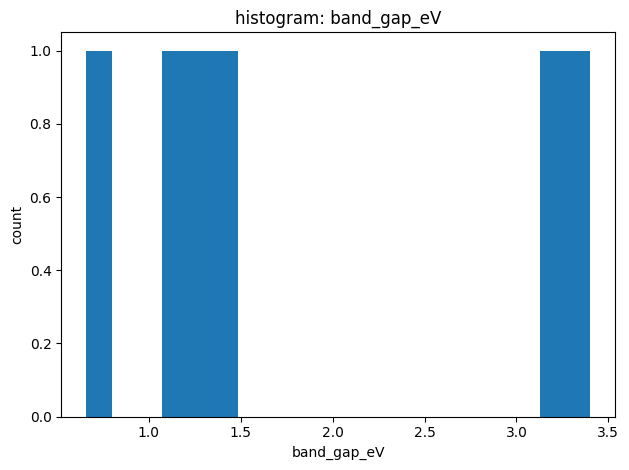

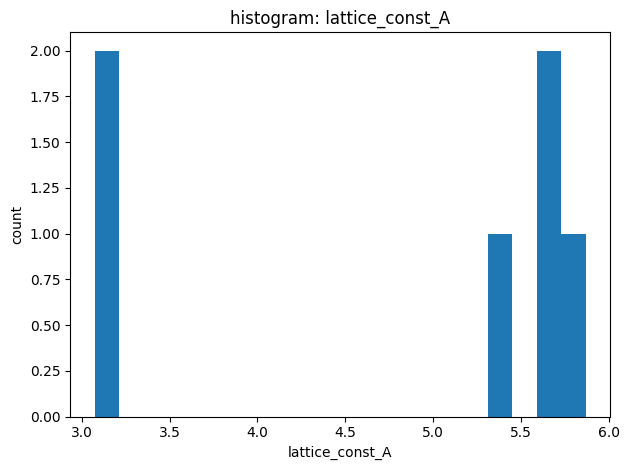

In [27]:
import matplotlib.pyplot as plt

for col in ["band_gap_eV", "lattice_const_A"]:
    series = df[col].dropna()
    plt.figure()
    plt.hist(series, bins=20)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"histogram: {col}")
    plt.tight_layout()
    plt.show()


b.5: Top categories (by structure & synthesis route)


Top 15 crystal_structure:
 crystal_structure
Diamond cubic    2
Zinc blende      2
Wurtzite         1
Hexagonal        1
Name: count, dtype: Int64


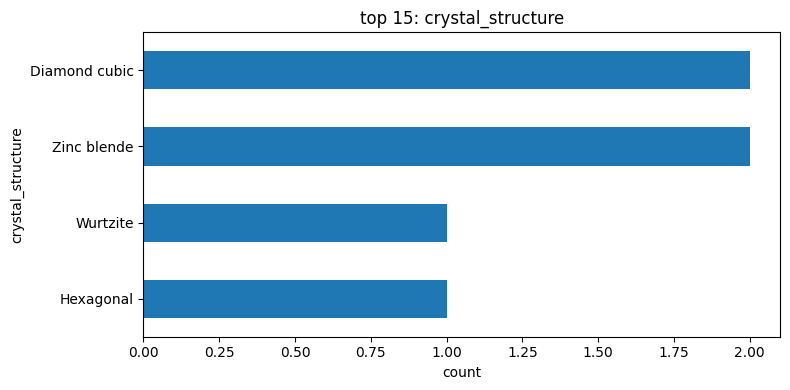


Top 15 typical_synthesis:
 typical_synthesis
Czochralski    2
MOCVD          2
MBE            1
PVT            1
Name: count, dtype: Int64


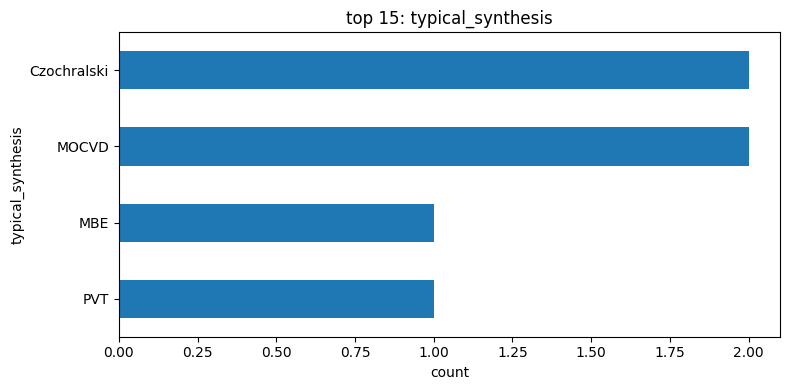

In [28]:
for col, k in [("crystal_structure", 15), ("typical_synthesis", 15)]:
    if col in df.columns:
        counts = df[col].dropna().value_counts().head(k)
        print(f"\nTop {k} {col}:\n", counts)
        plt.figure(figsize=(8, 4))
        counts[::-1].plot(kind="barh")  # horizontal for readability
        plt.title(f"top {k}: {col}")
        plt.xlabel("count")
        plt.tight_layout()
        plt.show()


b.6: Scatter plot between lattice parameter and bandgap

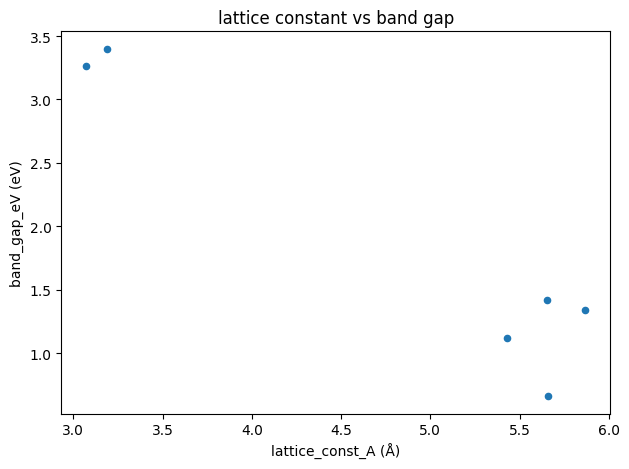

pearson r ≈ -0.960  (quick linear correlation)


In [29]:
x = df["lattice_const_A"]
y = df["band_gap_eV"]
mask = x.notna() & y.notna()

plt.figure()
plt.scatter(x[mask], y[mask], s=20)
plt.xlabel("lattice_const_A (Å)")
plt.ylabel("band_gap_eV (eV)")
plt.title("lattice constant vs band gap")
plt.tight_layout()
plt.show()

if mask.sum() >= 2:
    r = np.corrcoef(x[mask], y[mask])[0,1]
    print(f"pearson r ≈ {r:.3f}  (quick linear correlation)")


### looks sane → scale up with ollama

- i checked rows, types, missingness, distributions, and top categories.
- next: batch LLM normalization → mint IRIs → add triples.
- i’ll start small (e.g., 50 rows) and then go full dataset if everything behaves.

In [30]:
def normalize_batch(df, n=50, start=0):
    end = min(start + n, len(df))
    print(f"normalizing rows [{start}:{end}) ...")
    added = 0
    for i, row in df.iloc[start:end].iterrows():
        try:
            nr = normalize_row_with_ollama(row.to_dict())
            ingest_normalized_row(nr, idx=int(i))
            added += 1
            if added % 10 == 0:
                print(f"  +{added} rows -> triples: {len(g)}")
        except Exception as e:
            print(f"[warn] row {i}: {e}")
    print(f"done. added ~{added} rows. triples now: {len(g)}")

# try 50 first; adjust n as you like
normalize_batch(df, n=50, start=0)

normalizing rows [0:7) ...
done. added ~7 rows. triples now: 70
